# Computational and Variational Methods for Inverse Problems

## Assignment 2: Optimization methods and automatic differentiation

### (Notebook outline for problems 2, 3, and 4)

### Your name: Mohammad Afzal Shadab
(type your name here)

## Dependencies:

 - numpy
 - scipy
 - matplotlib
 - autograd (https://github.com/HIPS/autograd)

In [1]:
!conda install --yes autograd
import autograd.numpy as np
from autograd import grad, jacobian

import matplotlib.pyplot as plt
from scipy import optimize

Solving environment: done

# All requested packages already installed.



# 2) Discretized length and energy functionals

In this problem you will write code to compute the length functional $L(u)$ and energy functional $E(u)$ from problem 1, for continuous piecewise linear functions $u:[0,1]\rightarrow \mathbb{R}$ with equally spaced nodes. We assume that $u$ has $N+2$ equally spaced nodes at locations
$$0, h, 2h, 3h, \dots, Nh, 1$$
and that $u$ takes specified values at the nodes, and is piecewise linear in the intervals ("cells") between these nodes.

## 2a) Spatial derivative of piecewise linear function
Let $u(x)$ be a continuous piecewise linear function on $[0,1]$, with $N+2$ equally spaced nodes (including endpoints). The spatial derivative $\frac{du}{dx}$ is piecewise constant on the $N+1$ cells between neighboring nodes. An example of this is shown below.

Text(0.5, 1.0, 'du/dx')

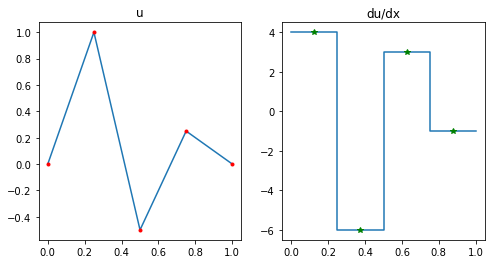

In [2]:
nodes = np.linspace(0.0, 1.0, 5)
u_at_nodes = np.array([0.0, 1.0, -0.5, 0.25, 0.0])

cell_centers = 0.5 * (nodes[1:] + nodes[:-1])
du_dx_in_cells = np.array([ 4., -6.,  3., -1.])

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.plot(nodes, u_at_nodes)
plt.plot(nodes, u_at_nodes, '.r')
plt.title('u')

plt.subplot(1,2,2)
plt.plot(nodes, np.concatenate([du_dx_in_cells, [-1]]), drawstyle='steps-post')
plt.plot(cell_centers, du_dx_in_cells, '*g')
plt.title('du/dx')

### Your task:
Write a function called "spatial\_derivative" that takes the length-$(N+2)$ vector of nodal values for $u$ as input, and returns the length-$N+1$ vector of cell values of $\frac{du}{dx}$ as output.

In [3]:
def spatial_derivative(u_at_nodes):
    
    dx = 1/(len(u_at_nodes) - 1) # Cell width = L/(N+1) = L/((N+2)-1)
    
    du_dx_in_cells = (u_at_nodes[1:] - u_at_nodes[:-1])/dx

    return du_dx_in_cells

### Test:
Error should be close to machine epsilon (around $10^{-14}$ or smaller)

In [4]:
u = np.array([0.25, -0.66,  0.70, -0.41, -1.02, 0.57,  0.13, -1.27,  0.83, -1.21])
du_dx_true = np.array([-8.19,  12.24,  -9.99,  -5.49,  14.31,  -3.96, -12.6,  18.9, -18.36])

du_dx = spatial_derivative(u)
spatial_derivative_error = np.linalg.norm(du_dx - du_dx_true)
print('spatial_derivative_error=', spatial_derivative_error)

spatial_derivative_error= 5.7044291861996796e-15


## 2b) Arc length function

In Problem 1 you showed that the arc length of a function $u:[0,1]\rightarrow \mathbb{R}$ is given by
$$L(u) = \int_0^1 \sqrt{1 + \left(\frac{du}{dx}(x)\right)^2}  dx$$

### Your task:
Let $u$ be a continuous piecewise linear function on $[0,1]$, with $N+2$ equally spaced nodes, including endpoints (the same setup as in 2a). Write a function called "length\_functional" that takes the vector of $N+2$ nodal values of $u$ as input, and returns the arc length of $u$ as output.

#### Hint:
The integrand is a piecewise constant function.

In [5]:
def length_functional(u_at_nodes):
    dx = 1/(len(u_at_nodes) - 1) # Cell width = L/(N+1) = L/((N+2)-1)
    spat_der = spatial_derivative(u_at_nodes)
    L = sum(np.sqrt(1 + spat_der**2)*dx)
    return L

### Test
Error should be close to machine epsilon (around $10^{-14}$ or smaller)

In [6]:
xx = np.linspace(0.0, 1.0, 100)
u = np.sqrt(1.0 / 2.0 - np.power(xx - 0.5, 2))
L_true = 1.1107087105088733

L = length_functional(u)
length_functional_error = np.abs(L - L_true)
print('length_functional_error=', length_functional_error)

length_functional_error= 6.661338147750939e-16


## 2c) Energy functional

Let $u$ be the height of an idealized hanging chain, and for convenience let the linear density of the chain be $\rho=1/g$, where the $g$ is the gravitational constant. From Problem 1 we know that the potential energy functional for such a hanging chain is given by
$$E(u) = \int_0^1 u(x) \sqrt{1 + \left(\frac{du}{dx}(x)\right)^2}  dx.$$

### Your task
Write a function named "energy\_functional" that takes as input the length $N+2$ vector of nodal values for a continuous piecewise linear function $u$ on $[0,1]$ as input (including values at the endpoints, as in 2a and 2b), and returns the energy functional $E(u)$ as output.

#### Hint:
The integrand is a **discontinuous** piecewise linear function because it is the product of a continuous piecewise linear function with a piecewise constant function.

In [7]:
def energy_functional(u_at_nodes):

    dx = 1/(len(u_at_nodes) - 1) # Cell width = L/(N+1) = L/((N+2)-1)
    spat_der = spatial_derivative(u_at_nodes)
    E = sum(0.5*(u_at_nodes[1:] + u_at_nodes[:-1])*np.sqrt(1 + spat_der**2)*dx)
    
    return E

### Test
Error should be close to machine epsilon (around $10^{-14}$ or smaller)

In [8]:
xx = np.linspace(0.0, 1.0, 75)
u = -np.sin(np.pi * xx)
E_true = -1.2379425688273515

E = energy_functional(u)
energy_functional_error = np.abs(E - E_true)
print('energy_functional_error=', energy_functional_error)

energy_functional_error= 2.220446049250313e-16


# 3)  Objective function, Gradient, and Hessian

In problem 1 we saw that the hanging chain problem may be written as the following constrained optimization problem:

\begin{align}
\min_u &\quad E(u) \\
\text{such that} &\quad L(u) = L_0.
\end{align}

We may find approximate solutions to this problem by solving the following unconstrained optimization problem,
$$\min_u E(u) + \alpha (L(u) - L_0)^2$$
where we use a quadratic penalty to approximately enforce the constraint. Here $\alpha > 0$ is a penalty parameter; as $\alpha \rightarrow \infty$, the solution to the unconstrained optimization problem approaches the solution of the constrained optimization problem.

Let
$$J(u) := E(u) + \alpha (L(u) - L_0)^2$$
denote the unconstrained objective function. In this problem, you will implement this objective function for continuous piecewise linear functions with equally spaced nodes, and use **automatic differentiation** to compute the gradient of $J$, the Hessian of $J$, and matrix-vector products of the Hessian of $J$ with arbitrary vectors. You will also compare the gradient and Hessian of $J$ to approximate gradients and Hessians computed with finite differences with a variety of step sizes.

## Objective function
The objective function may be written as follows, using your energy and length functional code from the previous problem. Note that the objective function only operates on the $N$ interior nodes for $u$, since the endpoints of $u$ are fixed at zero.

In [9]:
def objective_function(u_at_interior_nodes, alpha, L0):
    u_at_nodes = np.hstack([np.array([0.0]),
                                     u_at_interior_nodes,
                                     np.array([0.0])])
    
    E = energy_functional(u_at_nodes)
    L = length_functional(u_at_nodes)
    J = E + alpha * np.power(L - L0, 2)
    return J

If you were unable to complete the previous problem, you may uncomment the following (intentionally obfsucated) implementation and use it instead:

In [10]:
# def objective_function(u_at_interior_vertices, alpha, L0):
#     u = np.concatenate([np.array([0]),
#                         u_at_interior_vertices,
#                         np.array([0])])
#     a = 1./(len(u)-1.)
#     b, c = (u[1:]-u[:-1])/a, 0.5*(u[1:] + u[:-1])
#     return a*np.sum(c*np.sqrt(1.+np.power(b,2)))+alpha*np.power(a*np.sum(np.sqrt(1.+np.power(b,2)))-L0,2)

## 3a) Gradient via automatic differentiation

Here we will use the "grad" function in the python automatic differentiation tool **autograd** to compute the gradient of your objective function. Here is a quick example of how to use it. More details can be found here:
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md

### autodiff grad example

In [11]:
def f(x, a, b):
    return np.cos(a * x[0]) + np.sin(b * x[1])

grad_autodiff = grad(f, 0) # 0 indicates differentiation w.r.t. the first argument of f.

x = np.random.randn(2)
a = 1.3
b = -2.1
grad_at_x_autodiff = grad_autodiff(x, a, b)

grad_at_x_analytic = np.array([- a * np.sin(a * x[0]), 
                                 b * np.cos(b * x[1])])

autodiff_error = np.linalg.norm(grad_at_x_analytic - grad_at_x_autodiff)
print('autodiff_error=', autodiff_error)

autodiff_error= 0.0


### Your task:
Use automatic differentiation to create a function named "compute\_gradient" that computes the gradient of the objective function, $g$, at a given $u$ for a given penalty parameter $\alpha$ and chain length $L_0$.

### Hint:
The code is a one-liner

In [12]:
# Construct the function compute_gradient(u_at_interior_nodes, alpha, L0)
def compute_gradient(u_at_interior_nodes, alpha, L0):
    grad_autodiff = grad(objective_function, 0)
    return grad_autodiff(u_at_interior_nodes, alpha, L0)

### Finite difference check:
On one hand, the directional derivative of $J$ in direction $p$ may be computed from the gradient at $u$, $g(u)$, as follows:
$$\frac{d J}{d u}(u) p = g(u)^T p.$$
On the other hand, we may approximate the directional derivative via finite differences
$$\frac{d J}{du}(u) p \approx \frac{J(u + s p) - J(u)}{s}$$
where $s$ is some small scalar.

This allows us to check our gradient by choosing a random direction $p$, and comparing the result of computing $\frac{d J}{d u}(u) p$ in these two different ways. 

The error should be roughly the same order of magnitude as the step size.

In [13]:
N = 53
alpha = 8.95
L0 = 2.13
u1 = np.random.randn(N)
J1 = objective_function(u1, alpha, L0)

p = np.random.randn(N)
s = 1e-7 # step size
u2 = u1 + s*p

J2 = objective_function(u2, alpha, L0)
dJ_du_p_diff = (J2 - J1) / s

g = compute_gradient(u1, alpha, L0)
dJ_du_p = np.dot(g, p)

grad_err = np.abs( (dJ_du_p - dJ_du_p_diff) / dJ_du_p_diff )
print('step size=', s, ', gradient finite difference error=', grad_err)

step size= 1e-07 , gradient finite difference error= 7.875470862771769e-07


## 3b) Gradient finite difference plot

It is good practice to check your gradient with finite difference checks for a wide range of step sizes $s$, and make a log-log plot of the finite difference error as a function of $s$. If your gradient is working correctly, the resulting plot should look like a 'V', where the error decreases linearly from $s=10^0$ until somewhere around $s=10^{-5}$ to $s=10^{-9}$, then goes up again and/or becomes jagged.

### Example finite difference plot

step size= 1.0 , example gradient finite difference error= 0.1869222424524513
step size= 0.1 , example gradient finite difference error= 0.00349093452167874
step size= 0.01 , example gradient finite difference error= 0.00021854333414250828
step size= 0.001 , example gradient finite difference error= 2.055431862674754e-05
step size= 0.0001 , example gradient finite difference error= 2.0424348250662593e-06
step size= 1e-05 , example gradient finite difference error= 2.0412916377206068e-07
step size= 1e-06 , example gradient finite difference error= 2.0369046920227754e-08
step size= 1e-07 , example gradient finite difference error= 1.2950566966906895e-09
step size= 1e-08 , example gradient finite difference error= 7.787795534963471e-09
step size= 1e-09 , example gradient finite difference error= 2.874822313213768e-08
step size= 1e-10 , example gradient finite difference error= 3.7808855372400296e-07
step size= 1e-11 , example gradient finite difference error= 1.0767684826762245e-06
step s

Text(0, 0.5, 'error')

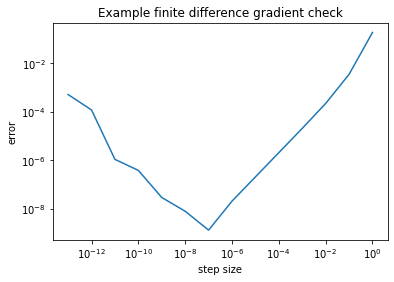

In [14]:
def f(x):
    return np.sin(x[0]) + np.cos(x[1])

def df_dx(x):
    return np.array([np.cos(x[0]), -np.sin(x[1])])

x1 = np.random.randn(2)
p = np.random.randn(2)
step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]

f1 = f(x1)
g1 = df_dx(x1)
df_dx_p = np.dot(g1, p)

grad_errs = list()
for s in step_sizes:
    x2 = x1 + s*p

    f2 = f(x2)
    df_dx_p_diff = (f2 - f1) / s

    grad_err = np.abs( (df_dx_p - df_dx_p_diff) / df_dx_p_diff )
    print('step size=', s, ', example gradient finite difference error=', grad_err)
    
    grad_errs.append(grad_err)

plt.loglog(step_sizes, grad_errs)
plt.title('Example finite difference gradient check')
plt.xlabel('step size')
plt.ylabel('error')

### Your task:
Perform finite difference checks on the hanging chain gradient for a wide range  of step sizes $s$, and make a log-log plot of the finite difference error as a function of $s$. See 3a for an example of a finite difference check for a single step size.

step size= 1.0 , gradient finite difference error= 1.5359221045221785
step size= 0.1 , gradient finite difference error= 0.05048493307123709
step size= 0.01 , gradient finite difference error= 0.011611967825265137
step size= 0.001 , gradient finite difference error= 0.0012955206658956029
step size= 0.0001 , gradient finite difference error= 0.00013085834362065523
step size= 1e-05 , gradient finite difference error= 1.309849323324684e-05
step size= 1e-06 , gradient finite difference error= 1.3085570655726142e-06
step size= 1e-07 , gradient finite difference error= 1.406116058554826e-07
step size= 1e-08 , gradient finite difference error= 4.3438666542285325e-08
step size= 1e-09 , gradient finite difference error= 5.666777934707982e-07
step size= 1e-10 , gradient finite difference error= 1.0271735177357446e-05
step size= 1e-11 , gradient finite difference error= 0.00024019298180859812
step size= 1e-12 , gradient finite difference error= 0.00013358885413378176
step size= 1e-13 , gradient f

Text(0, 0.5, 'error')

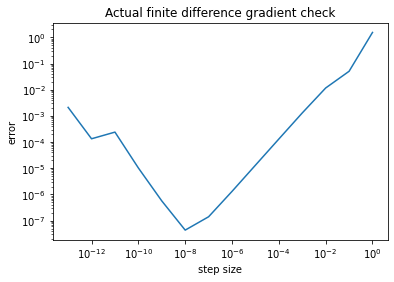

In [15]:
N = 53
alpha = 8.95
L0 = 2.13
u1 = np.random.randn(N)
p = np.random.randn(N)
step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]


# Make log-log plot of gradient finite difference error vs. step size
grad_errs = list()
for s in step_sizes:
    J1 = objective_function(u1, alpha, L0)
    u2 = u1 + s*p

    J2 = objective_function(u2, alpha, L0)
    dJ_du_p_diff = (J2 - J1) / s

    g = compute_gradient(u1, alpha, L0)
    dJ_du_p = np.dot(g, p)

    grad_err = np.abs( (dJ_du_p - dJ_du_p_diff) / dJ_du_p_diff )
    print('step size=', s, ', gradient finite difference error=', grad_err)

    grad_errs.append(grad_err)

plt.loglog(step_sizes, grad_errs)
plt.title('Actual finite difference gradient check')
plt.xlabel('step size')
plt.ylabel('error')

## 3c) Hessian-vector product via automatic differentiation

The Hessian is the derivative of the gradient, so the matrix-vector multiplication $H(u)p$ of the Hessian at $u$, $H(u)$, with a vector, $p$ is given by
$$H(u)p = \frac{d}{du} \left(\frac{d J}{du}(u) p\right) = \frac{d}{du} \left(g(u)^T p\right).$$
In other words, $H(u) p$ is the gradient of the scalar-valued function
$$q(u) := g(u)^T p,$$
and this gradient may be calculated by automatic differentiation.

### Example:

In [16]:
def f(x, a, b):
    return np.cos(a * x[0]) + np.sin(b * x[1])

compute_grad_f = grad(f, 0)

def q(x, p, a, b):
    g = compute_grad_f(x, a, b)
    return np.dot(g, p)

hessian_vector_product_f = grad(q, 0)

a = 1.4
b = 4.1
x = np.random.randn(2)
p = np.random.randn(2)

Hp_autodiff = hessian_vector_product_f(x, p, a, b)

H_analytic = np.array([[-a*a*np.cos(a * x[0]),                     0],
                       [0,                     -b*b*np.sin(b * x[1])]])

Hp_analytic = np.dot(H_analytic, p)

hess_prod_err = np.linalg.norm(Hp_analytic - Hp_autodiff) / np.linalg.norm(Hp_analytic)
print('example hessian vector product error=', hess_prod_err)

example hessian vector product error= 1.6136414068954485e-17


### Your task:
Use autodiff's grad function to create a function named "compute\_hessian\_vector\_product" that computes the Hessian-vector product $H(u)p$.

In [17]:
# Construct the function compute_hessian_vector_product(u_at_interior_nodes, p_at_interior_nodes, alpha, L0)

def compute_hessian_vector_product(u_at_interior_nodes, p_at_interior_nodes, alpha, L0):
    
    def compute_q(u_at_interior_nodes, p_at_interior_nodes, alpha, L0):
    
        return np.dot(compute_gradient(u_at_interior_nodes, alpha, L0), p_at_interior_nodes)
    
    hessian_vector_product = grad(compute_q, 0)
    
    return hessian_vector_product(u_at_interior_nodes, p_at_interior_nodes, alpha, L0)

### Finite difference check
The error should be roughly the same order of magnitude as the step size.

In [18]:
N = 53
alpha = 8.95
L0 = 2.13
u1 = np.random.randn(N)
G1 = compute_gradient(u1, alpha, L0)

p = np.random.randn(N)
s = 1e-7
u2 = u1 + s * p
G2 = compute_gradient(u2, alpha, L0)

Hp_diff = (G2 - G1) / s

Hp = compute_hessian_vector_product(u1, p, alpha, L0)

hessian_vector_product_error = np.linalg.norm(Hp - Hp_diff) / np.linalg.norm(Hp_diff)

print('s=', s, ', hessian vector product finite difference error=', hessian_vector_product_error)

s= 1e-07 , hessian vector product finite difference error= 1.6587773772162207e-06


## 3d) Hessian-vector product finite difference check plot

### Your task:
Construct a log-log plot of the Hessian finite difference error for a wide range of step sizes.

step size= 1.0 , Hessian vector product finite difference error= 1.4733264942668998
step size= 0.1 , Hessian vector product finite difference error= 0.6346241309628482
step size= 0.01 , Hessian vector product finite difference error= 0.5139721052617849
step size= 0.001 , Hessian vector product finite difference error= 0.052443872206184176
step size= 0.0001 , Hessian vector product finite difference error= 0.005252524457037228
step size= 1e-05 , Hessian vector product finite difference error= 0.0005253373249476569
step size= 1e-06 , Hessian vector product finite difference error= 5.2534585137139e-05
step size= 1e-07 , Hessian vector product finite difference error= 5.253690801857948e-06
step size= 1e-08 , Hessian vector product finite difference error= 5.27649027501531e-07
step size= 1e-09 , Hessian vector product finite difference error= 1.681720222985377e-07
step size= 1e-10 , Hessian vector product finite difference error= 2.2173519665320995e-06
step size= 1e-11 , Hessian vector prod

Text(0, 0.5, 'error')

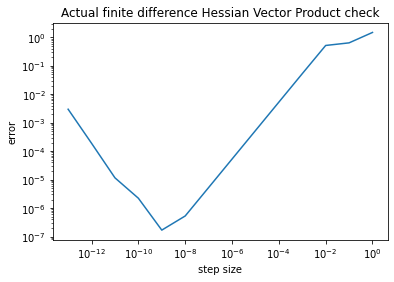

In [35]:
N = 53
alpha = 8.95
L0 = 2.13
u1 = np.random.randn(N)
p = np.random.randn(N)
step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]


# Make log-log plot of gradient finite difference error vs. step size

# Make log-log plot of gradient finite difference error vs. step size
hvp_errs = list()
for s in step_sizes:
    G1 = compute_gradient(u1, alpha, L0)
    u2 = u1 + s*p

    G2 = compute_gradient(u2, alpha, L0)
    Hp_diff = (G2 - G1) / s

    Hp = compute_hessian_vector_product(u1, p, alpha, L0)

    hessian_vector_product_error = np.linalg.norm(Hp - Hp_diff) / np.linalg.norm(Hp_diff)
    
    print('step size=', s, ', Hessian vector product finite difference error=', hessian_vector_product_error)

    hvp_errs.append(hessian_vector_product_error)

plt.loglog(step_sizes, hvp_errs)
plt.title('Actual finite difference Hessian Vector Product check')
plt.xlabel('step size')
plt.ylabel('error')

### Comparison with dense Hessian

The  $N \times N$ Hessian matrix is the Jacobian of the gradient, which can also be computed via automatic differentiation. This is not recommended for large problems.

Here we show how to compute the  Hessian using the Jacobian function in autograd.

In [36]:
compute_hessian = jacobian(compute_gradient, 0)

### Test dense Hessian
Error should be of the order machine epsilon (less than $10^{-14}$)

In [37]:
N = 15
alpha = 8.95
L0 = 2.13
u1 = np.random.randn(N)

H = compute_hessian(u1, alpha, L0)

p = np.random.randn(N)
Hp_dense = np.dot(H, p)
Hp = compute_hessian_vector_product(u1, p, alpha, L0)

dense_hessian_error = np.linalg.norm(Hp_dense - Hp) / np.linalg.norm(Hp)
print('dense_hessian_error=', dense_hessian_error)

dense_hessian_error= 5.452183358094436e-16


# 4) Comparison of optimization methods

In this problem, we will minimize $J$ using the method of steepest descent, BFGS, and the Newton-Conjugate-Gradient method. We will also plot convergence curves, and estimate the rate of convergence for these methods.

We will show you how to do this using BFGS as an example, and you will do this for steepest descent and Newton-CG.

### Problem parameters

For this problem, please use $N=32$, $L_0 = 3.0$, and $\alpha=1e2$.

In [125]:
N = 32
L0 = 3.0
alpha = 1e2

# Useful versions of the objective, gradient, 
# and hessian-vector product functions
J_func = lambda u: objective_function(u, alpha, L0)
g_func = lambda u: compute_gradient(u, alpha, L0)
Hp_func = lambda u, p: compute_hessian_vector_product(u, p, alpha, L0)

### Initial guess

A reasonable initial guess is the parabola
$$u_0(x) = -C x(1-x)$$
with constant 
$$C = 2 \left(L_0 - 1\right).$$
The constant $C$ is chosen to make the arc length of $u$ close to $L_0$. The formula for $C$ can be derived by the sum of the lengths of the left, right, and bottom edges of the box that bounds the parabola.

In [126]:
xx_including_endpoints = np.linspace(0.0, 1.0, N+2)

C = -2.0 * (L0 - 1.0)
u0_including_endpoints = C * xx_including_endpoints * (1.0-xx_including_endpoints)
u0 = u0_including_endpoints[1:-1]

### Example: BFGS

In [127]:
u = u0.copy()
JJ_bfgs = list()
def callback(uk):
    JJ_bfgs.append(J_func(uk))
    
sol = optimize.minimize(J_func, u0, method='BFGS', jac=g_func, callback=callback, tol=1e-6)
print(sol)
    
u = sol.x

      fun: -2.1828846090866403
 hess_inv: array([[ 4.76614309,  4.32921597,  4.50868564, ..., -1.38540055,
        -1.29635647, -0.70594892],
       [ 4.32921597,  7.8336242 ,  6.80731278, ..., -2.12046235,
        -1.95203868, -1.41083079],
       [ 4.50868564,  6.80731278,  8.28272541, ..., -2.02096186,
        -1.69409649, -1.13120152],
       ...,
       [-1.38540055, -2.12046235, -2.02096186, ...,  8.05547285,
         6.53813243,  4.05944663],
       [-1.29635647, -1.95203868, -1.69409649, ...,  6.53813243,
         7.573566  ,  4.70291914],
       [-0.70594892, -1.41083079, -1.13120152, ...,  4.05944663,
         4.70291914,  5.58777352]])
      jac: array([ 7.45418060e-08, -2.99932720e-08, -6.03720791e-08, -9.02942750e-08,
        1.47976609e-08,  1.15480308e-07,  4.82054802e-07, -2.66124608e-07,
        9.74273363e-08,  2.00760671e-07, -1.01914675e-08,  4.94058143e-07,
       -8.00367851e-09,  2.90389738e-07, -6.67694002e-07,  8.53019851e-07,
        9.76693287e-07,  1.8795170

### BFGS: check that solution gradient is small and plot the solution

||g(u)|| / ||g(u_0)||= 2.626689594166103e-08


Text(0, 0.5, 'u(x)')

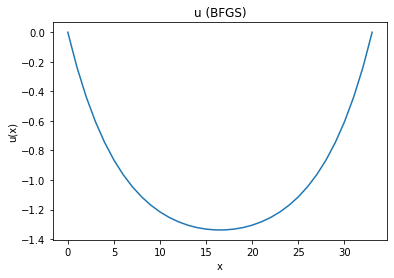

In [128]:
norm_g0 = np.linalg.norm(g_func(u0))
norm_g = np.linalg.norm(g_func(u))
print('||g(u)|| / ||g(u_0)||=', norm_g / norm_g0) # should be less than 1e-6

u_including_endpoints = np.concatenate([[0], u, [0]])

plt.figure()
plt.plot(u_including_endpoints)
plt.title('u (BFGS)')
plt.xlabel('x')
plt.ylabel('u(x)')

### BFGS: Make a convergence plot and estimate convergence rate

Asymptotically, the error should decrease as
$$J(u_{k+1}) - J(u_*) \le c \left(J(u_k) - J(u_*)\right)^q$$
for some constant $c$ and convergence rate $q$, where $u_*$ is the solution to the optimization problem. 

We can estimate the convergence rate, $q$, by plotting $J(u_{k+1}) - J(u_*)$ vs. $J(u_k) - J(u_*)$ on a log-log plot and finding the slope. We use the final value of $J$ as the solution $J(u_*)$. 

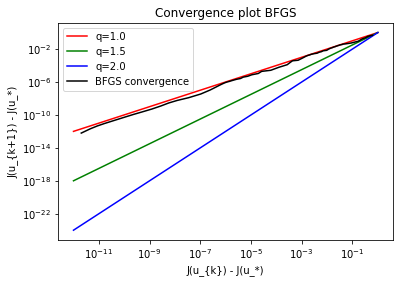

In [129]:
kk = np.logspace(-12, 0, 13)
yy10 = np.power(kk, 1.0)
yy15 = np.power(kk, 1.5)
yy20 = np.power(kk, 2.0)
plt.loglog(kk, yy10, 'r')
plt.loglog(kk, yy15, 'g')
plt.loglog(kk, yy20, 'b')

plt.loglog(JJ_bfgs[:-2] - JJ_bfgs[-1], JJ_bfgs[1:-1] - JJ_bfgs[-1], 'k')
plt.title('Convergence plot BFGS')
plt.ylabel('J(u_{k+1}) - J(u_*)')
plt.xlabel('J(u_{k}) - J(u_*)')
plt.legend(['q=1.0', 'q=1.5', 'q=2.0', 'BFGS convergence'])

## 4a) Steepest descent

The method of steepest descent minimizes the function $J(u)$ via the iteration
$$u_{k+1} = u_k - \beta
_kg(u_k)$$
where $u_k$ is the $k\text{th}$ iterate, $g(u_k)$ is the gradient at the $k\text{th}$ iterate, and $\beta_k$ is a step size parameter.

### Your task:

Minimize $J$ using the method of steepest descent. You should write your own steepest descent code for this (do not use existing steepest descent libraries).

Continue iterating until $||g_k|| < 10^{-6} ||g_0||$ or smaller. This should require several thousand iterations.

Save the function values $J(u_k)$ for all iterations so we can plot the convergence.


#### Hint: step size

The trick here is choosing $\beta_k$. If $\beta_k$ is too large, the method may become unstable and diverge. If $\beta_k$ is too small, the method will converge slowly. 

A popular option is to choose a step length satisfying the Wolfe conditions:

https://en.wikipedia.org/wiki/Wolfe_conditions

You may use the function scipy.optimize.line_search to find a step length satisfying these conditions:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.line_search.html#scipy.optimize.line_search

In [170]:
u = u0.copy() # update u each iteration
J0 = J_func(u)
g0 = g_func(u)
norm_g0 = np.linalg.norm(g0)

JJ_sd = list()
JJ_sd.append(J0) # Keep appending the value of J to this list each iteration

g = g0.copy()
k=0
#print(u,g)
# Solve optimization problem using method of steepest descent. 
while np.linalg.norm(g_func(u))/np.linalg.norm(g0) > 1e-6:
    #calculate step size beta_k using 
    beta_k = optimize.line_search(J_func, g_func, np.array(u), -np.array(g_func(u)))[0]
    #beta_k = 1e-3
    print(k,beta_k) 
    #update u
    u = u - beta_k * g_func(u)
    k = k+1
    
# Now the solution should be in the variable u
# and JJ_sd should be a list, with JJ[k] = J(u_k)

JJ_sd = np.array(JJ_sd) # Make JJ_sd into array instead of list

0 0.008160571336080467
1 0.00276389685761771
2 0.0025568613378211757
3 0.003298556107840456
4 0.011685204840756353
5 0.0032947125189943774
6 0.01173928985192457
7 0.003290918655250221
8 0.011793357575877855
9 0.003287171949274401
10 0.011847430928492119
11 0.003283469973884197
12 0.01190153227761406
13 0.0032798104322949925
14 0.011955683488641098
15 0.0032761911493331434
16 0.012009905968430741
17 0.003272610063258707
18 0.012064220706423517
19 0.003269065218264957
20 0.01211864831383896
21 0.003265554757506222
22 0.012173209060481699
23 0.003262076916783426
24 0.012227922909706772
25 0.003258630018580989
26 0.012282809552826165
27 0.0032552124666049014
28 0.012337888440556413
29 0.0032518227407467163
30 0.012393178813828771
31 0.00324845939234081
32 0.01244869973454119
33 0.0032451210398420052
34 0.012520796813774444
35 0.003239617469537142
36 0.012609832074830364
37 0.003234177963728711
38 0.01269948400162485
39 0.0032287998300128866
40 0.012789786207290139
41 0.003223480494551467
4

338 0.032679124757209806
339 0.0030683000379016765
340 0.03140573799437338
341 0.003083346611289907
342 0.03024443979475062
343 0.0030982900988283605
344 0.02918036480001474
345 0.0031131436338725127
346 0.028201213014095113
347 0.003136103568060462
348 0.026080810081503945
349 0.0031674044392073575
350 0.02432825225551784
351 0.0031979131907555274
352 0.022850912845649534
353 0.0032279209657164257
354 0.021581909649261818
355 0.0032575203663623227
356 0.020477742752364986
357 0.003286785529136691
358 0.019506521941718154
359 0.0033157772344625676
360 0.01864427940781793
361 0.0033445463365551404
362 0.017872617439217513
363 0.003373136146568421
364 0.017177155428764787
365 0.0034015841370117566
366 0.016546474098955058
367 0.0034299231915497323
368 0.01597137933146772
369 0.003458182541493384
370 0.015444377362597728
371 0.0034863884808276945
372 0.014959293271004889
373 0.0035145649218308
374 0.014510988783289097
375 0.0035427338334044736
376 0.014095150275921906
377 0.00357091559167

671 0.01077604156225521
672 0.004905406943853866
673 0.010425853435581207
674 0.0049912120190978865
675 0.01010569067507441
676 0.005078005564441688
677 0.009811472976879999
678 0.005165925244355603
679 0.009539835604771112
680 0.005255109682307342
681 0.009287976390847665
682 0.005345700135258801
683 0.009053540724371032
684 0.005437842051901165
685 0.008834533881633057
686 0.0055316865760325976
687 0.008629253345930695
688 0.005627392046490804
689 0.008436235954482297
690 0.0057251255370475715
691 0.008254216185544337
692 0.005825064477388266
693 0.008082092914911172
694 0.0059273983966778784
695 0.007918902683248264
696 0.006032330829896241
697 0.007763798017533691
698 0.006140081433137142
699 0.0076160297132797875
700 0.006306387361680339
701 0.007319878310761306
702 0.006538351088704995
703 0.007055168777643027
704 0.006779996381503823
705 0.006816440144658401
706 0.0070327665130280855
707 0.006599414664519011
708 0.007298298770756178
709 0.006400684789826323
710 0.007578478174258

1016 0.01223620995499027
1017 1.0
1018 0.01253260824733953
1019 1.0
1020 0.01898598323953104
1021 0.03862269820551557
1022 0.016442579229207294
1023 0.06068503369843799
1024 0.01547587240198762
1025 0.10166201987441009
1026 0.014080833775404155
1027 0.17835809525301036
1028 0.013730395460154147
1029 0.29184188160061947
1030 0.013416075727033457
1031 1.0
1032 0.013178506957245094
1033 0.366987108041326
1034 0.014255049267722688
1035 0.1431356559855903
1036 0.015112899244141796
1037 0.10945517047279246
1038 0.015639851898386098
1039 0.0918182378473515
1040 0.01609777477720366
1041 0.08057333824818072
1042 0.01652979271468633
1043 0.07249097776071452
1044 0.01694620960957187
1045 0.06632600607495026
1046 0.01735298717582944
1047 0.06142536887806546
1048 0.017754099095322693
1049 0.05740896358945605
1050 0.01815246273927452
1051 0.054038576269688485
1052 0.018550383907704276
1053 0.05115638810239258
1054 0.018949797439860458
1055 0.04877424658903357
1056 0.01931483880209952
1057 0.04678535

1349 0.41985379112538945
1350 0.018388365263490653
1351 1.0
1352 0.017867355921110394
1353 4.0
1354 0.01962704972168786
1355 0.25637287211188914
1356 0.019874350572686016
1357 0.22885092061377704
1358 0.02008904905055593
1359 0.2079639468130329
1360 0.020292206596222724
1361 0.1918825673756292
1362 0.020484088133243688
1363 0.17877611614463898
1364 0.020668054306676495
1365 0.1680006034371611
1366 0.020844603047565056
1367 0.15888497206456384
1368 0.021015000633693135
1369 0.15109086825362078
1370 0.021180175293462614
1371 0.14429227923980134
1372 0.021341288076524367
1373 0.13829280729343854
1374 0.021499214382255796
1375 0.13293065721344138
1376 0.02165459735639978
1377 0.12809981665221976
1378 0.021807858608632078
1379 0.12371507669425061
1380 0.02195929850849885
1381 0.1197127146100196
1382 0.022109151562122405
1383 0.11604028262492239
1384 0.022257614408937015
1385 0.11265535939342214
1386 0.022404860029325676
1387 0.109522540630104
1388 0.022551042518511165
1389 0.106612237897486

1684 0.08280427402618788
1685 0.02580343967820955
1686 0.08418921790109984
1687 0.025684007059693936
1688 0.08561907941257743
1689 0.02556594515567986
1690 0.08709647594608184
1691 0.02544920058964472
1692 0.08862423706205974
1693 0.025333721169020613
1694 0.0902054269280486
1695 0.025219455779721508
1696 0.09184336966864988
1697 0.025106354287312754
1698 0.09354167807666704
1699 0.025034212542271915
1700 0.09416759661772185
1701 0.025001962561244012
1702 0.09479416351836836
1703 0.024953913735422186
1704 0.09590168753878363
1705 0.024890454617046833
1706 0.09702767971002911
1707 0.024827866313324
1708 0.0981726854684019
1709 0.024766128877135536
1710 0.09933727227409207
1711 0.02470522293357651
1712 0.10091650592366812
1713 0.02459812691081676
1714 0.10293774534325235
1715 0.024493731676795742
1716 0.10501163539162597
1717 0.02439193426389532
1718 0.10714054292459133
1719 0.024292636820764543
1720 0.10932698316862187
1721 0.024195746283812644
1722 0.1115736320636649
1723 0.02410117408

2017 0.025557582087875716
2018 0.11738424475760582
2019 0.025496889748248788
2020 0.11879372905850422
2021 0.025436779717954317
2022 0.12023148863338544
2023 0.025377242155574783
2024 0.12169845409758996
2025 0.025318266318613745
2026 0.12319561658298145
2027 0.025259841146807464
2028 0.12472402326322676
2029 0.025201955527836006
2030 0.12628477629894375
2031 0.025144598432496987
2032 0.1278790341117775
2033 0.025087758975423004
2034 0.12950801374148935
2035 0.025031426448170645
2036 0.13117299362591114
2037 0.02498630434010092
2038 0.13227462954628139
2039 0.024952178662929436
2040 0.13338650159320412
2041 0.024918447436619244
2042 0.13450874926704748
2043 0.024885104684015735
2044 0.13564151464547453
2045 0.02485214454793291
2046 0.13678494246807335
2047 0.02481956128776589
2048 0.13793917995241278
2049 0.024787349288580614
2050 0.1391043765730359
2051 0.024755503057653973
2052 0.14028068417844675
2053 0.024724017223227722
2054 0.1414682569857431
2055 0.02469288651041032
2056 0.14266

2344 0.13897373404287336
2345 0.02535832177342086
2346 0.13843980530830594
2347 0.025375547279707547
2348 0.13808312538273773
2349 0.025387116651786893
2350 0.13788846385932413
2351 0.025393543430147887
2352 0.1378369966107414
2353 0.02539545770485064
2354 0.13790905032687908
2355 0.025393517042575774
2356 0.13808584579633243
2357 0.025388349232730943
2358 0.13835043227315916
2359 0.025380521341654083
2360 0.1386880500967606
2361 0.025370527363476284
2362 0.1390861467138723
2363 0.025358787511778308
2364 0.13953419963876498
2365 0.025345653947347842
2366 0.14002345345167844
2367 0.025331419369901347
2368 0.14054663658872987
2369 0.025316326386912613
2370 0.14109768870680708
2371 0.025300576490230806
2372 0.14167151685504273
2373 0.025284338170483894
2374 0.14226377988312863
2375 0.025267753938944842
2376 0.14287070645962321
2377 0.02525094635523097
2378 0.1434889357455706
2379 0.025234023182522176
2380 0.14411537959831588
2381 0.025217081826083086
2382 0.144747097704019
2383 0.02520021

2670 0.14944696440650138
2671 0.025327728174699363
2672 0.14836043734348814
2673 0.025361309819041566
2674 0.14723469531402938
2675 0.025396037254899792
2676 0.14610938097670081
2677 0.02543073916180264
2678 0.145023602933816
2679 0.02546424354122922
2680 0.14401176405394375
2681 0.02549550475111797
2682 0.14310043902088163
2683 0.0255237026718014
2684 0.14230685806880863
2685 0.025548295665333648
2686 0.1416389920723114
2687 0.02556902383946452
2688 0.14109688863273348
2689 0.02558587321483438
2690 0.14067462557437854
2691 0.02559901779439476
2692 0.14036240639582742
2693 0.02560875606514318
2694 0.14014838780219058
2695 0.025615453938732664
2696 0.14002010019897035
2697 0.02561949985061066
2698 0.13996542151476712
2699 0.025621273489851975
2700 0.13997316028284587
2701 0.025621126743182166
2702 0.1400333512062998
2703 0.025619373840520945
2704 0.14013734378817655
2705 0.025616288166705144
2706 0.14027775892538752
2707 0.025612103151615703
2708 0.14044839154429242
2709 0.0256070153494

3005 0.02532863959690092
3006 0.15355144993224987
3007 0.025324529679069764
3008 0.15371944028642726
3009 0.02532053904363922
3010 0.15388309464014135
3011 0.025316682131436345
3012 0.15404181852910917
3013 0.025312975940717478
3014 0.15419488326970363
3015 0.025309439998170112
3016 0.15434147175412252
3017 0.02530609758982412
3018 0.15448058740626197
3019 0.025302976088151713
3020 0.15461108700090606
3021 0.025300107279215178
3022 0.15473162968940324
3023 0.02529752846082676
3024 0.15484065136353609
3025 0.02529528327423043
3026 0.15493632420542278
3027 0.02529342276326289
3028 0.1550165251030541
3029 0.025292006211870346
3030 0.15507878875620276
3031 0.025291102645814773
3032 0.1551202942649716
3033 0.025290790803000368
3034 0.15513782381105234
3035 0.0252911612897796
3036 0.1551277266671721
3037 0.025292316933868405
3038 0.1550859163106508
3039 0.0252943725031036
3040 0.15500792563898538
3041 0.025297454714725446
3042 0.15488892692749842
3043 0.025301700392400085
3044 0.154723880419

3333 0.025382749397719336
3334 0.1535788252558679
3335 0.02538083086056594
3336 0.15365673510062625
3337 0.025378950908154896
3338 0.15373319758851137
3339 0.025377111266408982
3340 0.153808265211806
3341 0.025375313949315928
3342 0.15388162922548157
3343 0.02537356628858257
3344 0.15395318318494375
3345 0.02537187103684362
3346 0.15402272993708405
3347 0.02537023438569368
3348 0.15409006067012637
3349 0.025368661104717114
3350 0.15415492904309447
3351 0.02536715938416772
3352 0.1542170563237059
3353 0.025365736192926237
3354 0.15427613672867885
3355 0.025364399893102713
3356 0.1543318169679704
3357 0.025363162630971152
3358 0.15438364460689805
3359 0.025362033433490423
3360 0.15443122411824575
3361 0.025361026690737636
3362 0.15447400365068012
3363 0.025360156434853294
3364 0.15451139430307742
3365 0.0253594400423142
3366 0.15454269268778426
3367 0.02535889601281968
3368 0.1545672184872987
3369 0.025358544387382585
3370 0.15458414650315552
3371 0.025358409461850414
3372 0.154592475444

### Test:

||g(u)|| / ||g(u_0)||= 1.0


Text(0, 0.5, 'u(x)')

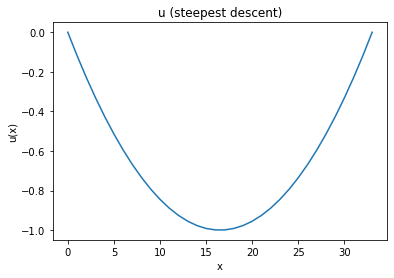

In [28]:
norm_g = np.linalg.norm(g_func(u))
print('||g(u)|| / ||g(u_0)||=', norm_g / norm_g0) # should be less than 1e-6

u_including_endpoints = np.concatenate([[0], u, [0]])

plt.figure()
plt.plot(u_including_endpoints)
plt.title('u (steepest descent)')
plt.xlabel('x')
plt.ylabel('u(x)')

## 4b) Steepest descent convergence

Asymptotically, the error should decrease as
$$J(u_{k+1}) - J(u_*) \le c \left(J(u_k) - J(u_*)\right)^q$$
for some constant $c$ and convergence rate $q$, where $u_*$ is the solution to the optimization problem. 

### Your task:

Estimate the convergence rate, $q$, by plotting $J(u_{k+1}) - J(u_*)$ vs. $J(u_k) - J(u_*)$ on a log-log plot and finding the slope. You may use the final value of $J$ as the solution $J(u_*)$. 

In [29]:
# Make a log-log convergence plot for steepest descent and estimate the convergence rate

####    VVVV   YOUR CODE GOES HERE    VVVV    ####















####    ^^^^   YOUR CODE GOES HERE    ^^^^    ####

## 4c) Newton-CG

### Your task:

Minimize $J$ using the Newton-CG method implemented in scipy.optimize.minimize:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

https://docs.scipy.org/doc/scipy/reference/optimize.minimize-newtoncg.html

 - Use a tolerance of $10^{-6}$

 - Save the intermediate values of $J(u_k)$ so that we can study convergence.


### Hint:
To save intermediate values of $J(u_k)$, use a "callback" function.

In [30]:
u = u0.copy()
JJ_ncg = list()
def callback(uk):
    JJ_ncg.append(J_func(uk))

sol = optimize.minimize(####    YOUR CODE HERE    ####)
print(sol)
    
u = sol.x

SyntaxError: invalid syntax (<ipython-input-30-96c346a72d35>, line 9)

### Test

In [ ]:
norm_g = np.linalg.norm(g_func(u))
print('||g(u)|| / ||g(u_0)||=', norm_g / norm_g0) # should be less than 1e-6

u_including_endpoints = np.concatenate([[0], u, [0]])

plt.figure()
plt.plot(u_including_endpoints)
plt.title('u (Newton-CG)')
plt.xlabel('x')
plt.ylabel('u(x)')

## 4d) Newton-CG convergence

Asymptotically, the error should decrease as
$$J(u_{k+1}) - J(u_*) \le c \left(J(u_k) - J(u_*)\right)^q$$
for some constant $c$ and convergence rate $q$, where $u_*$ is the solution to the optimization problem. 

### Your task:

Estimate the convergence rate, $q$, for Newton-CG by plotting $J(u_{k+1}) - J(u_*)$ vs. $J(u_k) - J(u_*)$ on a log-log plot and estimating the slope. You may use the final value of $J$ as the solution $J(u_*)$. 

In [ ]:
# Make a log-log convergence plot for Newton-CG and estimate the convergence rate

####    VVVV   YOUR CODE GOES HERE    VVVV    ####












####    ^^^^   YOUR CODE GOES HERE    ^^^^    ####